In [ ]:
# Install necessary libraries
!pip install numpy pandas scikit-learn xgboost matplotlib seaborn openpyxl pytorch-tabnet rouge-score sacrebleu shap psutil

# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import time
import joblib

# Function to load data
def load_data(file_path):
    data = pd.read_excel(file_path)
    print(f"Data loaded successfully! Dataset shape: {data.shape}")
    return data

# Function to preprocess data
def preprocess_data(data, target_column):
    if "PatientID" in data.columns:
        data = data.drop("PatientID", axis=1)

    label_encoders = {}
    for col in data.select_dtypes(include=["object", "category"]).columns:
        if col != target_column:
            label_encoders[col] = LabelEncoder()
            data[col] = label_encoders[col].fit_transform(data[col])

    X = data.drop(target_column, axis=1)
    y = data[target_column]
    return X, y, label_encoders

# Function to split data
def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

# Function to train the model
def train_model(X_train, y_train, learning_rate=0.1, max_depth=6, n_estimators=100):
    model = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth,
                          n_estimators=n_estimators, verbosity=0, use_label_encoder=False)
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    print(f"Training Time: {end_time - start_time:.2f} seconds")
    return model

# Main pipeline function for training and saving the model
def train_and_save_model(file_path, target_column, model_save_path, encoders_save_path):
    # Load and preprocess data
    data = load_data(file_path)
    X, y, label_encoders = preprocess_data(data, target_column)
    X_train, X_test, y_train, y_test = split_data(X, y)

    # Train the model
    model = train_model(X_train, y_train)

    # Save the model and label encoders
    joblib.dump(model, model_save_path)
    joblib.dump(label_encoders, encoders_save_path)
    print(f"Model and label encoders saved to {model_save_path} and {encoders_save_path}.")

# Run the training and saving process
if __name__ == "__main__":
    file_path = "/content/cleaned_patient_data.xlsx"  # Update with your dataset path
    target_column = "HadHeartAttack"  # Update with your target column name
    model_save_path = "/content/trained_model.pkl"  # Path to save the trained model
    encoders_save_path = "/content/label_encoders.pkl"  # Path to save the label encoders

    train_and_save_model(file_path, target_column, model_save_path, encoders_save_path)


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.1 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=cf9be795916edb3ef960b1de752e2c0a791265796ee097a86f90edb2f3b96d8d
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score
Data loaded successfully! Dataset shape: (237630, 36)
Training Time: 2.95 seconds
Model and label encoders saved to /content/trained_model.pkl and /content/label_encoders.pkl.


In [ ]:
# Install necessary libraries
#!pip install numpy pandas scikit-learn xgboost matplotlib seaborn openpyxl pytorch-tabnet rouge-score sacrebleu shap psutil

# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import time
import joblib
from rouge_score import rouge_scorer
import sacrebleu

# Function to load data
def load_data(file_path):
    data = pd.read_excel(file_path)
    print(f"Data loaded successfully! Dataset shape: {data.shape}")
    return data

# Function to preprocess data
def preprocess_data(data, target_column, label_encoders):
    if "PatientID" in data.columns:
        data = data.drop("PatientID", axis=1)

    for col, encoder in label_encoders.items():
        data[col] = encoder.transform(data[col])

    X = data.drop(target_column, axis=1)
    y = data[target_column]
    return X, y

# Function to split data
def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    return y_pred, accuracy

# BLEU and ROUGE evaluation
def evaluate_text_metrics(y_true, y_pred):
    # Convert labels to strings for text-based evaluation
    y_true = [str(label).strip() for label in y_true]
    y_pred = [str(pred).strip() for pred in y_pred]

    # Debug: Print true and predicted labels
    print("Sample True Labels:", y_true[:10])  # Show the first 10 for debugging
    print("Sample Predicted Labels:", y_pred[:10])

    # BLEU Score
    bleu = sacrebleu.corpus_bleu(y_pred, [y_true]).score

    # ROUGE Score
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = rouge.score("\n".join(y_true), "\n".join(y_pred))

    # Aggregate ROUGE scores into a single value
    rouge_aggregate = (
        rouge_scores['rouge1'].fmeasure +
        rouge_scores['rouge2'].fmeasure +
        rouge_scores['rougeL'].fmeasure
    ) / 3

    print(f"BLEU Score: {bleu:.2f}")
    print(f"ROUGE Aggregate Score: {rouge_aggregate:.2f}")
    return bleu, rouge_aggregate

# Main pipeline function for evaluation
def evaluate_model_from_saved(model_path, encoders_path, file_path, target_column):
    # Load the trained model and label encoders
    model = joblib.load(model_path)
    label_encoders = joblib.load(encoders_path)

    # Load and preprocess data
    data = load_data(file_path)
    X, y = preprocess_data(data, target_column, label_encoders)
    X_train, X_test, y_train, y_test = split_data(X, y)

    # Evaluate the model
    y_pred, accuracy = evaluate_model(model, X_test, y_test)

    # Additional Evaluations
    bleu, rouge_aggregate = evaluate_text_metrics(y_test, y_pred)

    return {
        "accuracy": accuracy,
        "bleu": bleu,
        "rouge": rouge_aggregate
    }

# Run the evaluation
if __name__ == "__main__":
    model_path = "/content/trained_model.pkl"  # Path to the saved trained model
    encoders_path = "/content/label_encoders.pkl"  # Path to the saved label encoders
    file_path = "/content/cleaned_patient_data.xlsx"  # Update with your dataset path
    target_column = "HadHeartAttack"  # Update with your target column name

    results = evaluate_model_from_saved(model_path, encoders_path, file_path, target_column)
    print("\nEvaluation Results:")
    for key, value in results.items():
        print(f"{key.capitalize()}: {value}")


Data loaded successfully! Dataset shape: (237630, 36)
Accuracy: 0.9463
Sample True Labels: ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Sample Predicted Labels: ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


In [ ]:
# Install necessary libraries
!pip install numpy pandas scikit-learn xgboost matplotlib seaborn openpyxl pytorch-tabnet rouge-score sacrebleu shap psutil

# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import time
import joblib
from rouge_score import rouge_scorer
import sacrebleu

# Function to load data
def load_data(file_path):
    data = pd.read_excel(file_path)
    print(f"Data loaded successfully! Dataset shape: {data.shape}")
    return data

# Function to preprocess data
def preprocess_data(data, target_column, label_encoders):
    if "PatientID" in data.columns:
        data = data.drop("PatientID", axis=1)

    for col, encoder in label_encoders.items():
        data[col] = encoder.transform(data[col])

    X = data.drop(target_column, axis=1)
    y = data[target_column]
    return X, y

# Function to split data
def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    return y_pred, accuracy

# BLEU and ROUGE evaluation
def evaluate_text_metrics(y_true, y_pred):
    # Convert labels to strings for text-based evaluation
    y_true = [str(label) for label in y_true]
    y_pred = [str(pred) for pred in y_pred]

    bleu = sacrebleu.corpus_bleu(y_pred, [y_true]).score
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = rouge.score("\n".join(y_true), "\n".join(y_pred))

    print(f"BLEU Score: {bleu:.2f}")
    print(f"ROUGE Scores: {rouge_scores}")
    return bleu, rouge_scores

# Main pipeline function for evaluation
def evaluate_model_from_saved(model_path, encoders_path, file_path, target_column):
    # Load the trained model and label encoders
    model = joblib.load(model_path)
    label_encoders = joblib.load(encoders_path)

    # Load and preprocess data
    data = load_data(file_path)
    X, y = preprocess_data(data, target_column, label_encoders)
    X_train, X_test, y_train, y_test = split_data(X, y)

    # Evaluate the model
    y_pred, accuracy = evaluate_model(model, X_test, y_test)

    # Additional Evaluations
    bleu, rouge_scores = evaluate_text_metrics(y_test, y_pred)

    return {
        "accuracy": accuracy,
        "bleu": bleu,
        "rouge": rouge_scores
    }

# Run the evaluation
if __name__ == "__main__":
    model_path = "/content/trained_model.pkl"  # Path to the saved trained model
    encoders_path = "/content/label_encoders.pkl"  # Path to the saved label encoders
    file_path = "/content/cleaned_patient_data.xlsx"  # Update with your dataset path
    target_column = "HadHeartAttack"  # Update with your target column name

    results = evaluate_model_from_saved(model_path, encoders_path, file_path, target_column)
    print("\nEvaluation Results:")
    for key, value in results.items():
        print(f"{key.capitalize()}: {value}")


Data loaded successfully! Dataset shape: (237630, 36)
Accuracy: 0.9463


In [ ]:
# Install necessary libraries
!pip install numpy pandas scikit-learn xgboost shap matplotlib seaborn openpyxl psutil

# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
import joblib

# Function to load data
def load_data(file_path):
    data = pd.read_excel(file_path)
    print(f"Data loaded successfully! Dataset shape: {data.shape}")
    return data

# Function to preprocess data
def preprocess_data(data, target_column, label_encoders):
    if "PatientID" in data.columns:
        data = data.drop("PatientID", axis=1)

    for col, encoder in label_encoders.items():
        data[col] = encoder.transform(data[col])

    X = data.drop(target_column, axis=1)
    y = data[target_column]
    return X, y

# Function to split data
def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

# Function to generate and plot SHAP values
def generate_shap_values(model, X_test, feature_names):
    # Explain the model predictions using SHAP
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Summary plot
    print("Generating SHAP summary plot...")
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)

    # Bar plot for global feature importance
    print("Generating SHAP bar plot...")
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar")

    # Force plot for a single instance (optional)
    print("Generating SHAP force plot for the first instance...")
    shap.initjs()
    force_plot = shap.force_plot(
        explainer.expected_value, shap_values[0], X_test.iloc[0, :], feature_names=feature_names
    )
    return shap_values, force_plot

# Main function to load model and generate SHAP values
def shap_analysis_from_saved(model_path, encoders_path, file_path, target_column):
    # Load the trained model and label encoders
    model = joblib.load(model_path)
    label_encoders = joblib.load(encoders_path)

    # Load and preprocess data
    data = load_data(file_path)
    X, y = preprocess_data(data, target_column, label_encoders)
    X_train, X_test, y_train, y_test = split_data(X, y)

    # Generate SHAP values and plots
    feature_names = X_test.columns
    shap_values, force_plot = generate_shap_values(model, X_test, feature_names)

    return shap_values, force_plot

# Run SHAP analysis
if __name__ == "__main__":
    model_path = "/content/trained_model.pkl"  # Path to the saved trained model
    encoders_path = "/content/label_encoders.pkl"  # Path to the saved label encoders
    file_path = "/content/cleaned_patient_data.xlsx"  # Update with your dataset path
    target_column = "HadHeartAttack"  # Update with your target column name

    shap_values, force_plot = shap_analysis_from_saved(model_path, encoders_path, file_path, target_column)

    # Display the SHAP force plot for the first instance
    shap.force_plot(
        base_value=shap_values[0].mean(),
        shap_values=shap_values[0],
        features=None,
    )


In [ ]:
pip install lightgbm pandas scikit-learn matplotlib seaborn openpyxl numpy joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 34.9 MB/s eta 0:00:00


Data loaded successfully! Dataset shape: (237630, 36)
Training Time: 621.80 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     44886
           1       0.58      0.21      0.31      2640

    accuracy                           0.95     47526
   macro avg       0.77      0.60      0.64     47526
weighted avg       0.93      0.95      0.94     47526

Confusion Matrix:


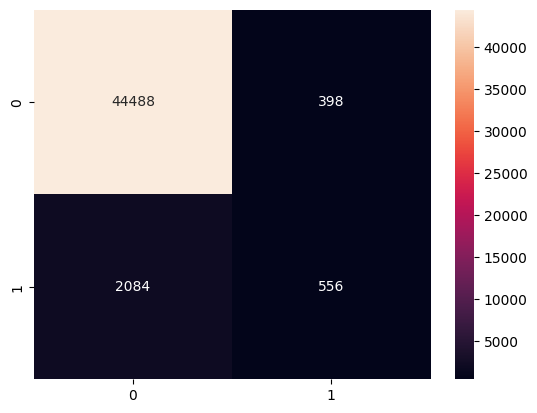


Evaluation Metrics:
ACCURACY: 0.9478
PRECISION: 0.5828
RECALL: 0.2106
F1: 0.3094
ROC_AUC: 0.8846


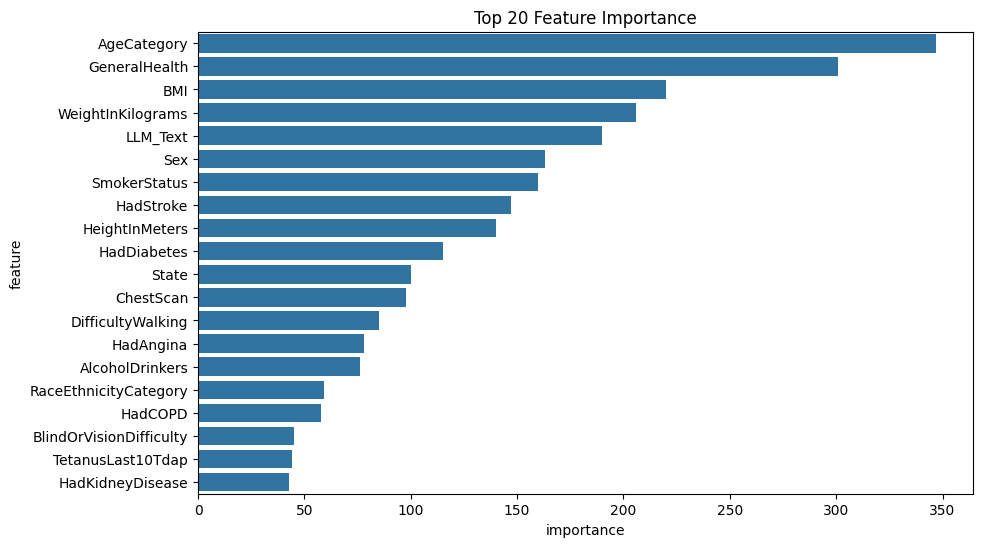

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score,
                            recall_score, f1_score, roc_auc_score,
                            confusion_matrix, classification_report)
import joblib
import time
import lightgbm as lgb  # More CPU-efficient than XGBoost
import matplotlib.pyplot as plt
import seaborn as sns

# Install required libraries
!pip install lightgbm pandas scikit-learn matplotlib seaborn openpyxl

# Optimized data loading
def load_data(file_path):
    data = pd.read_excel(file_path, engine='openpyxl')
    print(f"Data loaded successfully! Dataset shape: {data.shape}")
    return data

# Efficient preprocessing
def preprocess_data(data, target_column):
    # Drop non-predictive columns
    data = data.drop(["PatientID"], axis=1, errors='ignore')

    # Optimized label encoding
    label_encoders = {}
    for col in data.select_dtypes(include=["object", "category"]).columns:
        if col != target_column:
            label_encoders[col] = LabelEncoder()
            data[col] = label_encoders[col].fit_transform(data[col].astype(str))

    X = data.drop(target_column, axis=1)
    y = data[target_column]
    return X, y, label_encoders

# LightGBM model training
def train_model(X_train, y_train):
    # Optimized parameters for CPU efficiency
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'n_jobs': -1  # Use all CPU cores
    }

    start_time = time.time()
    train_data = lgb.Dataset(X_train, label=y_train)
    model = lgb.train(params, train_data, num_boost_round=100)
    end_time = time.time()

    print(f"Training Time: {end_time - start_time:.2f} seconds")
    return model

# Enhanced evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_bin = (y_pred >= 0.5).astype(int)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_bin))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred_bin)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred_bin),
        'precision': precision_score(y_test, y_pred_bin),
        'recall': recall_score(y_test, y_pred_bin),
        'f1': f1_score(y_test, y_pred_bin),
        'roc_auc': roc_auc_score(y_test, y_pred)
    }

    print("\nEvaluation Metrics:")
    for k, v in metrics.items():
        print(f"{k.upper()}: {v:.4f}")

    return metrics

# Feature importance visualization
def plot_feature_importance(model, features):
    importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importance()
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance.head(20))
    plt.title('Top 20 Feature Importance')
    plt.show()

# Main pipeline
def main():
    file_path = "/content/cleaned_patient_data.xlsx"
    target_column = "HadHeartAttack"

    # Load and preprocess data
    data = load_data(file_path)
    X, y, label_encoders = preprocess_data(data, target_column)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train model
    model = train_model(X_train, y_train)

    # Evaluate
    metrics = evaluate_model(model, X_test, y_test)

    # Save model
    joblib.dump(model, 'trained_model2.pkl')
    joblib.dump(label_encoders, 'label_encoders2.pkl')

    # Feature importance
    plot_feature_importance(model, X.columns.tolist())

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import pandas as pd
import shap
import psutil
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score,
                            recall_score, f1_score, roc_auc_score,
                            confusion_matrix, classification_report)
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

# Install required libraries
!pip install lightgbm pandas scikit-learn matplotlib seaborn openpyxl shap psutil nltk rouge-score
!python -m nltk.downloader punkt

# Optimized data loading
def load_data(file_path):
    data = pd.read_excel(file_path, engine='openpyxl')
    print(f"Data loaded successfully! Dataset shape: {data.shape}")
    return data

# Efficient preprocessing
def preprocess_data(data, target_column):
    data = data.drop(["PatientID"], axis=1, errors='ignore')
    label_encoders = {}
    for col in data.select_dtypes(include=["object", "category"]).columns:
        if col != target_column:
            label_encoders[col] = LabelEncoder()
            data[col] = label_encoders[col].fit_transform(data[col].astype(str))
    X = data.drop(target_column, axis=1)
    y = data[target_column]
    return X, y, label_encoders

# Modified training function with resource tracking
def train_model(X_train, y_train):
    process = psutil.Process()
    start_time = time.time()
    start_mem = process.memory_info().rss

    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'n_jobs': -1
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    model = lgb.train(params, train_data, num_boost_round=100)

    training_time = time.time() - start_time
    mem_usage = (process.memory_info().rss - start_mem) / (1024 ** 2)  # MB

    return model, training_time, mem_usage

# SHAP analysis with CPU optimization
def shap_analysis(model, X_sample):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)

    # Summary plot
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.savefig('shap_summary.png', bbox_inches='tight')
    plt.close()

    return shap_values

# NLP metrics (note: not standard for classification tasks)
def calculate_nlp_metrics(y_true, y_pred):
    # Convert to string sequences for compatibility
    refs = [[str(int(y))] for y in y_true]
    hyps = [str(int(y)) for y in (y_pred >= 0.5).astype(int)]

    # BLEU Score
    bleu = sentence_bleu(refs, hyps)

    # ROUGE Scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(' '.join(hyps), ' '.join(refs[0]))

    return bleu, rouge_scores

# Enhanced evaluation with all metrics
def evaluate_model(model, X_test, y_test, shap_time):
    y_pred = model.predict(X_test)
    y_pred_bin = (y_pred >= 0.5).astype(int)

    # Traditional metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred_bin),
        'precision': precision_score(y_test, y_pred_bin),
        'recall': recall_score(y_test, y_pred_bin),
        'f1': f1_score(y_test, y_pred_bin),
        'roc_auc': roc_auc_score(y_test, y_pred),
        'shap_time': shap_time
    }

    # NLP metrics
    bleu, rouge = calculate_nlp_metrics(y_test, y_pred)
    metrics.update({
        'bleu': bleu,
        'rouge1': rouge['rouge1'].fmeasure,
        'rougeL': rouge['rougeL'].fmeasure
    })

    # Visualization
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_bin))

    plt.figure(figsize=(10, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred_bin), annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.show()

    return metrics

# Main pipeline with resource tracking
def main():
    file_path = "/content/cleaned_patient_data.xlsx"
    target_column = "HadHeartAttack"

    # Load and preprocess data
    data = load_data(file_path)
    X, y, label_encoders = preprocess_data(data, target_column)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train model with resource tracking
    model, train_time, mem_usage = train_model(X_train, y_train)

    # SHAP analysis on sample (CPU optimized)
    start_shap = time.time()
    shap_values = shap_analysis(model, X_test.sample(100, random_state=42))
    shap_time = time.time() - start_shap

    # Evaluate with all metrics
    metrics = evaluate_model(model, X_test, y_test, shap_time)
    metrics.update({
        'training_time': train_time,
        'memory_usage_mb': mem_usage
    })

    # Print final report
    print("\nFinal Evaluation Report:")
    for k, v in metrics.items():
        print(f"{k.upper():<20}: {v:.4f}" if isinstance(v, float) else f"{k.upper():<20}: {v}")

    # Save model
    joblib.dump(model, 'trained_model2.pkl')
    joblib.dump(label_encoders, 'label_encoders2.pkl')

if __name__ == "__main__":
    main()

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Data loaded successfully! Dataset shape: (237630, 36)


In [ ]:
# Install necessary libraries
!pip install transformers datasets torch pandas scikit-learn

# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

# Load data
def load_data(file_path):
    data = pd.read_excel(file_path)
    print(f"Data loaded successfully! Dataset shape: {data.shape}")
    return data

# Preprocess data
def preprocess_data(data, text_columns, target_column):
    # Combine selected features into a single text column
    data['text'] = data[text_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    # Keep only the necessary columns
    data = data[['text', target_column]]
    # Rename target column to 'labels' for Hugging Face compatibility
    data.rename(columns={target_column: "labels"}, inplace=True)
    # Convert the target column to integer type
    data["labels"] = data["labels"].astype(int)
    return data

# Split data
def split_data(data, test_size=0.2, random_state=42):
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=random_state)
    return train_data, test_data

# Prepare Dataset for Hugging Face
def prepare_dataset(data, tokenizer, max_length=128):
    def tokenize_function(example):
        return tokenizer(example["text"], padding="max_length", truncation=True, max_length=max_length)

    dataset = Dataset.from_pandas(data)
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    # Set the format for PyTorch training
    tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return tokenized_dataset

# Train the LLM model
def train_model(train_dataset, test_dataset, model_name, output_dir):
    # Force the model to use the CPU
    device = torch.device("cpu")
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=4,  # Reduced batch size for CPU
        per_device_eval_batch_size=4,  # Reduced batch size for CPU
        num_train_epochs=2,  # Fewer epochs for faster CPU training
        weight_decay=0.01,
        logging_dir='./logs',
        save_strategy="epoch",
        no_cuda=True,  # Disable CUDA explicitly
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
    )

    trainer.train()
    model.save_pretrained(output_dir)
    print(f"Model saved to {output_dir}")

# Main pipeline
if __name__ == "__main__":
    # File path and parameters
    file_path = "/content/cleaned_patient_data.xlsx"  # Update with your dataset path
    text_columns = [
        "State", "Sex", "GeneralHealth", "AgeCategory", "BMI", "HadAngina", "HadStroke",
        "HadAsthma", "HadSkinCancer", "HadCOPD", "HadDepressiveDisorder", "HadKidneyDisease",
        "HadArthritis", "HadDiabetes", "DeafOrHardOfHearing", "BlindOrVisionDifficulty",
        "DifficultyConcentrating", "DifficultyWalking", "DifficultyDressingBathing",
        "DifficultyErrands", "SmokerStatus", "ECigaretteUsage", "ChestScan", "RaceEthnicityCategory",
        "AlcoholDrinkers", "HIVTesting", "FluVaxLast12", "PneumoVaxEver", "TetanusLast10Tdap",
        "HighRiskLastYear", "CovidPos"
    ]  # Features combined into text
    target_column = "HadHeartAttack"  # Target column for classification
    model_name = "distilbert-base-uncased"  # Pre-trained LLM model
    output_dir = "/content/fine_tuned_llm"  # Directory to save fine-tuned model

    # Load and preprocess data
    data = load_data(file_path)
    data = preprocess_data(data, text_columns, target_column)
    train_data, test_data = split_data(data)

    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Prepare datasets
    train_dataset = prepare_dataset(train_data, tokenizer)
    test_dataset = prepare_dataset(test_data, tokenizer)

    # Train and save the model
    train_model(train_dataset, test_dataset, model_name, output_dir)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Data loaded successfully! Dataset shape: (237630, 36)


<ipython-input-2-88432ba6e8fb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={target_column: "labels"}, inplace=True)
<ipython-input-2-88432ba6e8fb>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["labels"] = data["labels"].astype(int)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google 

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/190104 [00:00<?, ? examples/s]

Map:   0%|          | 0/47526 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1590: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` 

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# Install necessary libraries
!pip install transformers datasets torch scikit-learn pandas

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd

# Load and preprocess
def load_and_preprocess(file_path, text_columns, target_column):
    data = pd.read_excel(file_path)
    data['text'] = data[text_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    return Dataset.from_pandas(data[['text', target_column]])

# Training pipeline
def train_llm(train_dataset, test_dataset, model_name="bert-base-uncased"):
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    train_args = TrainingArguments(
        output_dir="./model",
        evaluation_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir='./logs'
    )
    trainer = Trainer(
        model=model,
        args=train_args,
        train_dataset=train_dataset.map(lambda x: tokenizer(x["text"], truncation=True, padding=True), batched=True),
        eval_dataset=test_dataset.map(lambda x: tokenizer(x["text"], truncation=True, padding=True), batched=True),
        tokenizer=tokenizer,
    )
    trainer.train()

# Main
file_path = "/content/data.xlsx"
dataset = load_and_preprocess(file_path, ["Feature1", "Feature2"], "Target")
train_dataset, test_dataset = dataset.train_test_split(test_size=0.2).values()
train_llm(train_dataset, test_dataset)


In [ ]:
# Install necessary libraries
!pip install numpy pandas scikit-learn xgboost matplotlib seaborn openpyxl pytorch-tabnet rouge-score sacrebleu shap psutil

# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import time
import joblib
from rouge_score import rouge_scorer
import sacrebleu

# Function to load data
def load_data(file_path):
    data = pd.read_excel(file_path)
    print(f"Data loaded successfully! Dataset shape: {data.shape}")
    return data

# Function to preprocess data
def preprocess_data(data, target_column, label_encoders):
    if "PatientID" in data.columns:
        data = data.drop("PatientID", axis=1)

    for col, encoder in label_encoders.items():
        data[col] = encoder.transform(data[col])

    X = data.drop(target_column, axis=1)
    y = data[target_column]
    return X, y

# Function to split data
def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    return y_pred, accuracy

# BLEU and ROUGE evaluation
def evaluate_text_metrics(y_true, y_pred):
    # Convert labels to strings for text-based evaluation
    y_true = [str(label) for label in y_true]
    y_pred = [str(pred) for pred in y_pred]

    bleu = sacrebleu.corpus_bleu(y_pred, [y_true]).score
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = rouge.score("\n".join(y_true), "\n".join(y_pred))

    print(f"BLEU Score: {bleu:.2f}")
    print(f"ROUGE Scores: {rouge_scores}")
    return bleu, rouge_scores

# Main pipeline function for evaluation
def evaluate_model_from_saved(model_path, encoders_path, file_path, target_column):
    # Load the trained model and label encoders
    model = joblib.load(model_path)
    label_encoders = joblib.load(encoders_path)

    # Load and preprocess data
    data = load_data(file_path)
    X, y = preprocess_data(data, target_column, label_encoders)
    X_train, X_test, y_train, y_test = split_data(X, y)

    # Evaluate the model
    y_pred, accuracy = evaluate_model(model, X_test, y_test)

    # Additional Evaluations
    bleu, rouge_scores = evaluate_text_metrics(y_test, y_pred)

    return {
        "accuracy": accuracy,
        "bleu": bleu,
        "rouge": rouge_scores
    }

# Run the evaluation
if __name__ == "__main__":
    model_path = "/content/trained_model.pkl"  # Path to the saved trained model
    encoders_path = "/content/label_encoders.pkl"  # Path to the saved label encoders
    file_path = "/content/cleaned_patient_data.xlsx"  # Update with your dataset path
    target_column = "HadHeartAttack"  # Update with your target column name

    results = evaluate_model_from_saved(model_path, encoders_path, file_path, target_column)
    print("\nEvaluation Results:")
    for key, value in results.items():
        print(f"{key.capitalize()}: {value}")
